# Logistic Regression with K-Means clusters

**An experimental algorithm to cluster data and feature engineering based on "anomalies" in the data**

To ease the development of the algorithm, a class and multiple functions have been created. This will aid in time consuming tasks.

Redudant imports exists, which sole reason is for further experimentation.

In [1]:
from azureml.core import Workspace, Datastore, Dataset

from azureml.core.experiment import Experiment

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from pandas.plotting import parallel_coordinates

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


**Get data from Azure Machine Learning ressource and storage accounts**

In [2]:
ws = Workspace.from_config("./config/config_2")
az_store = Datastore.get(ws, 'azureml_ds_b01')
az_dataset = Dataset.get_by_name(ws, "Petrosani_01")
#az_dataset_Turda = Dataset.get_by_name(ws, "Turda_01")
az_default_store = ws.get_default_datastore()
df = az_dataset.to_pandas_dataframe()
#df_Turda_ = az_dataset_Turda.to_pandas_dataframe()

**Setup tools**

In [3]:
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()


def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P


# class for loading, initializing and training a logistic model with Kmeans clusters.
class clust():
    def _load_data(self, sklearn_load_ds):
        data = sklearn_load_ds
        X = pd.DataFrame(data[['Temp_Out', 'Temp_Room', 'FanSpeed']])
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, data['Abnormality'], test_size=0.3, random_state=42)
        
    def cmPlot(df):
        return plotCorrelationMatrix(df, 5)
        
    def __init__(self, sklearn_load_ds):
        self._load_data(sklearn_load_ds)
    
    
    def classify(self, model=LogisticRegression(random_state=42, warm_start=True, class_weight=2)):
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print('Accuracy: {}'.format(accuracy_score(self.y_test, y_pred)))


    def Kmeans(self, output='add'):
        n_clusters = len(np.unique(self.y_train))
        clf = KMeans(n_clusters = n_clusters, random_state=42)
        clf.fit(self.X_train)
        y_labels_train = clf.labels_
        y_labels_test = clf.predict(self.X_test)
        if output == 'add':
            self.X_train['km_clust'] = y_labels_train
            self.X_test['km_clust'] = y_labels_test
        elif output == 'replace':
            self.X_train = y_labels_train[:, np.newaxis]
            self.X_test = y_labels_test[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        return self

Raw data exploration

- Correlation matrix plotted, to observe any correlation in the raw data. 
- Transpose method used to get a statistical overview of the data.

C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


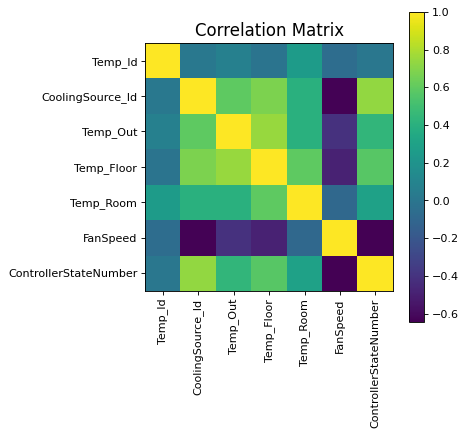

In [4]:
plotCorrelationMatrix(df, 5)

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp_Id,333629.0,1.848537e+06,710508.936198,196603.0,1240763.0,2145407.0,2537575.0,2754019.0
Location_Id,333629.0,2.069000e+03,0.000000,2069.0,2069.0,2069.0,2069.0,2069.0
CoolingSource_Id,333629.0,1.050688e-01,0.338319,0.0,0.0,0.0,0.0,2.0
Temp_Out,333629.0,9.744159e+00,8.933181,-19.8,2.7,8.7,15.6,43.0
Temp_Floor,333629.0,1.684418e+01,2.882096,6.2,14.9,16.2,17.4,30.9
Temp_Room,333629.0,2.559568e+01,1.027625,18.0,25.0,25.5,26.0,32.9
FanSpeed,333629.0,5.608807e+01,18.045047,0.0,54.0,59.0,64.0,90.0
ControllerStateNumber,333629.0,8.647105e+00,6.617204,4.0,7.0,7.0,7.5,84.0


**Create new features based on existing data**

This process is to get an indication of what can be classified as an anomali, for further use in the Regression Algorithm

In [ ]:
alldatestart = '2021-01-01'
alldateend = '2021-12-31'

# create features
mask = (df['Date_Id'] > alldatestart) & (df['Date_Id'] <= alldateend)
df_anom = df.loc[mask]
temp_threshhold = 10
fanspeed_threshhold = 15



# define temperatur difference indicator
df_anom['RoomTempHigher'] = np.where(df_anom['Temp_Room'] > (df_anom['Temp_Out'] - temp_threshhold), 1, 0)
df_anom['TempDifFromMean'] = np.where((df_anom['Temp_Room'] - df_anom['Temp_Out']) > (df_anom['Temp_Room'].mean() - (df_anom['Temp_Out'].mean() + temp_threshhold)), 1, 0)

# define fanspeed difference from mean indicator
df_anom['FanSpeedHigherThanMean'] = np.where(df_anom['FanSpeed'] > (df_anom['FanSpeed'].mean() + fanspeed_threshhold), 1, 0)

# define abnormality from above features
df_anom['Abnormality'] = np.where(((df_anom['FanSpeedHigherThanMean'] == 1) & (df_anom['RoomTempHigher'] == 1)), 1, 0)


df_anom['TempDiff'] = np.where(((df_anom['Temp_Room'] > df_anom['Temp_Out'])), df_anom['Temp_Room'] - df_anom['Temp_Out'], 0)
df_anom['FanFreq'] = np.where(((df_anom['FanSpeed'] > df_anom['FanSpeed'].mean())), df_anom['FanSpeed'] - df_anom['FanSpeed'].mean(), 0)

# define arobs
conditions = [
    (df_anom['FanSpeedHigherThanMean'] == 1) & (df_anom['RoomTempHigher'] == 1),
    (df_anom['FanSpeedHigherThanMean'] == 1) & (df_anom['RoomTempHigher'] == 0),
    (df_anom['FanSpeedHigherThanMean'] == 0) & (df_anom['RoomTempHigher'] == 1),
    (df_anom['FanSpeedHigherThanMean'] == 0) & (df_anom['RoomTempHigher'] == 0)
    ]
values = [1, 0, 0, 0]

# create a new column and use np.select to assign values to it using our lists as arguments
df_anom['Arobs'] = np.select(conditions, values)



Explore new features in statistical format and

In [7]:
select_df = df_anom.drop(['Location_Id', 'Date_Id', 'Arobs', 'Temp_Id'], 1)
select_df.describe().transpose()

C:\Users\OguzX\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,count,mean,std,min,25%,50%,75%,max
CoolingSource_Id,235784.0,0.136057,0.378323,0.0,0.0,0.000000,0.000000,2.000000
Temp_Out,235784.0,11.315058,9.053788,-12.6,4.2,10.500000,17.100000,43.000000
Temp_Floor,235784.0,17.261849,3.114469,6.6,15.1,16.500000,18.100000,30.900000
Temp_Room,235784.0,25.530122,1.130687,18.6,24.8,25.400000,25.900000,32.900000
FanSpeed,235784.0,55.295291,20.455000,0.0,54.0,59.000000,64.000000,90.000000
ControllerStateNumber,235784.0,9.081774,7.389760,4.0,7.0,7.000000,7.500000,84.000000
RoomTempHigher,235784.0,0.995593,0.066236,0.0,1.0,1.000000,1.000000,1.000000
TempDifFromMean,235784.0,0.894853,0.306743,0.0,1.0,1.000000,1.000000,1.000000
FanSpeedHigherThanMean,235784.0,0.091308,0.288047,0.0,0.0,0.000000,0.000000,1.000000
Abnormality,235784.0,0.091308,0.288047,0.0,0.0,0.000000,0.000000,1.000000


**Explore cluster K-means algorithm**

In [8]:
X = StandardScaler().fit_transform(select_df)

kmeans = KMeans(n_clusters=2)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(n_clusters=2)


In [9]:
centers = model.cluster_centers_
centers

array([[-0.35541826, -0.24839401, -0.28072083, -0.16874825,  0.29396499,
        -0.3049515 ,  0.06652879,  0.32988933, -0.00769343, -0.00769343,
         0.22264648,  0.05287329],
       [ 2.55933042,  1.78865976,  2.02144187,  1.21513882, -2.11681174,
         2.19592445, -0.47906696, -2.37549921,  0.05539963,  0.05539963,
        -1.60325445, -0.3807351 ]])

In [10]:
P = pd_centers(select_df, centers)
P

,CoolingSource_Id,Temp_Out,Temp_Floor,Temp_Room,FanSpeed,ControllerStateNumber,RoomTempHigher,TempDifFromMean,FanSpeedHigherThanMean,Abnormality,TempDiff,FanFreq,prediction
0,-0.355418,-0.248394,-0.280721,-0.168748,0.293965,-0.304952,0.066529,0.329889,-0.007693,-0.007693,0.222646,0.052873,0
1,2.559330,1.788660,2.021442,1.215139,-2.116812,2.195924,-0.479067,-2.375499,0.055400,0.055400,-1.603254,-0.380735,1


**Plotting out scaled values and define cluster**

Plotted values are fanspeed and out temps. The line indicates the two different clusters, which will be used for classification.

(-1.0, 1.5)

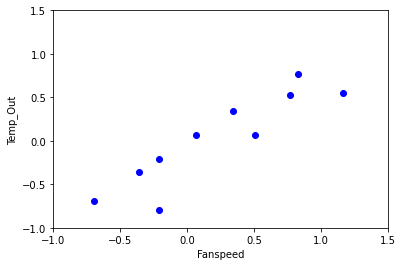

In [11]:
plt.scatter(X[10], X[5], c='b')

plt.xlabel('Fanspeed')
plt.ylabel('Temp_Out')
plt.title(label="")
plt.ylim(-1,1.5)
plt.xlim(-1,1.5)

(-1.0, 1.5)

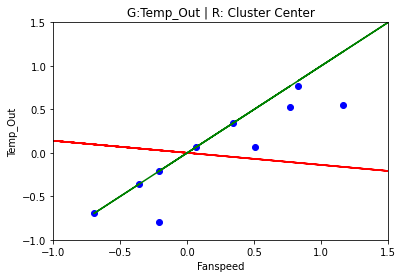

In [12]:
plt.scatter(X[10], X[5], c='b')
plt.plot(centers[1], centers[0], c='r')
plt.plot(X[10], X[10], c='g')

plt.xlabel('Fanspeed')
plt.ylabel('Temp_Out')
plt.title(label="G:Temp_Out | R: Cluster Center")
plt.ylim(-1,1.5)
plt.xlim(-1,1.5)

In [13]:
clus = clust(sklearn_load_ds=select_df)

result = clus.Kmeans(output='replace').classify()

Accuracy: 0.9077273241348112
